# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
np.random.seed(500)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99894938886724


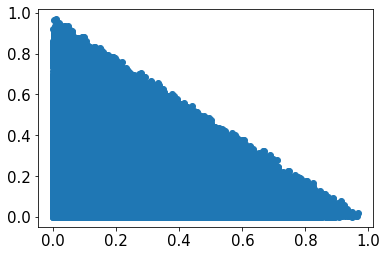

In [3]:
NumberofSources = 5
NumberofMixtures = 10
N = 5*1e5
S = 2*np.random.uniform(size = (NumberofSources,int(N)))-1
S = ProjectRowstoL1NormBall(S.T).T
S = S*(S>=0)
S = S #/ S.sum(axis = 0)
# https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
S = S / np.sum(S, axis = 0)
INPUT_STD = 0.17
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for M in range(A.shape[0]):
    stdx = np.std(X[M,:])
    A[M,:] = A[M,:]/stdx * INPUT_STD

SNR=30
X = A @ S
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

# Visualize Generated Sources and Mixtures

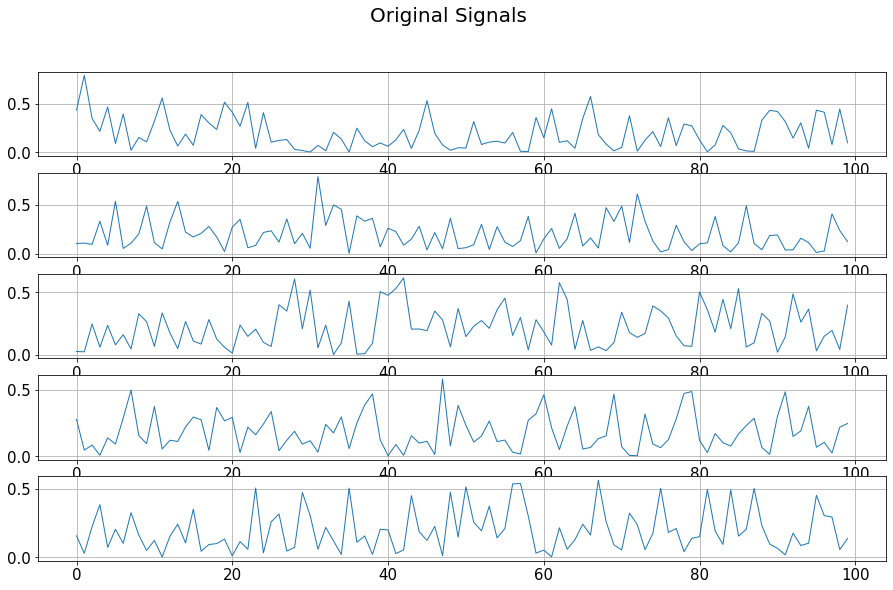

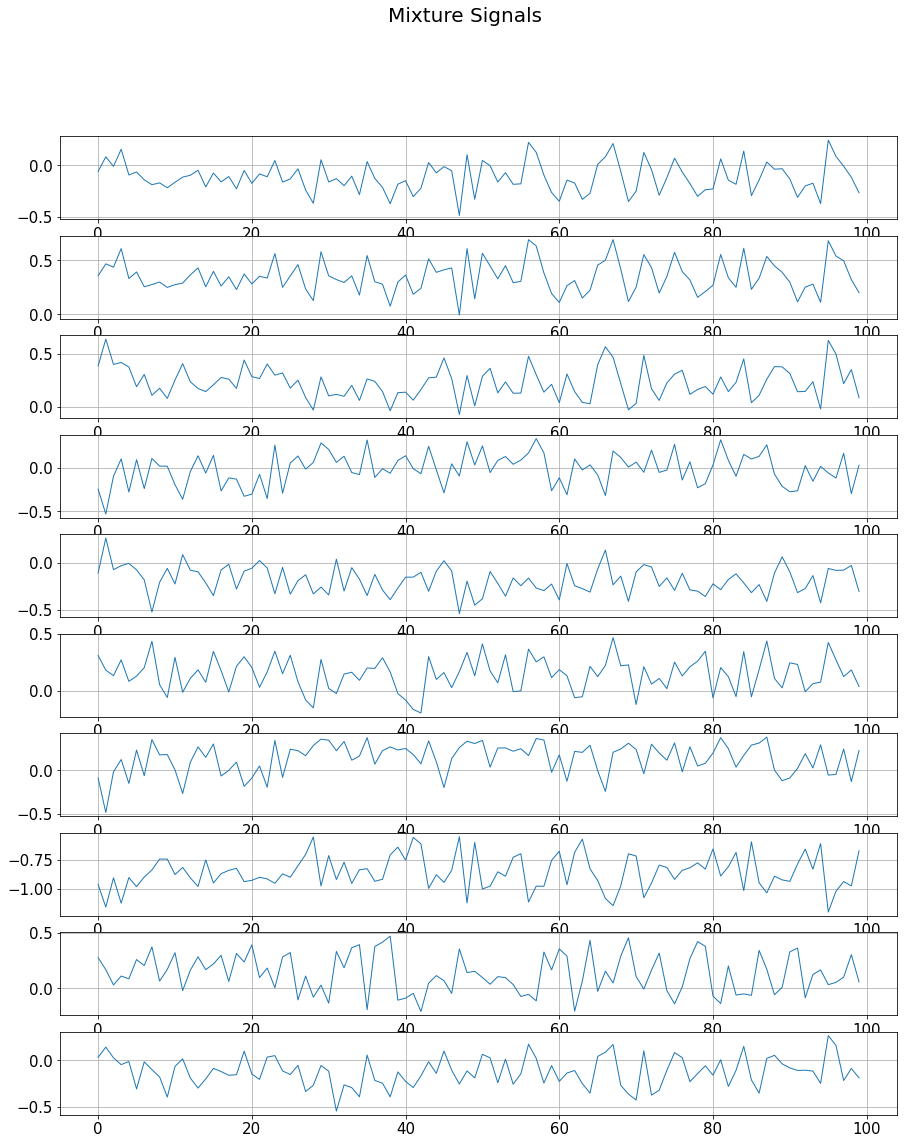

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
# MUS = 0.25
# OUTPUT_COMP_TOL = 1e-5
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [8,1]
# LayerMinimumGains = [1e-6,0.5]
# LayerMaximumGains = [1e6,2]
# WScalings = [0.0033,0.0033]
# GamScalings = [0.02,0.02]
# zeta = 1e-5
# beta = 0.5
# muD = [1, 0.01]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]

MUS = 0.1
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [8,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1e-5
beta = 0.5
muD = [1, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

# Run WSM Algorithm on Mixture Signals

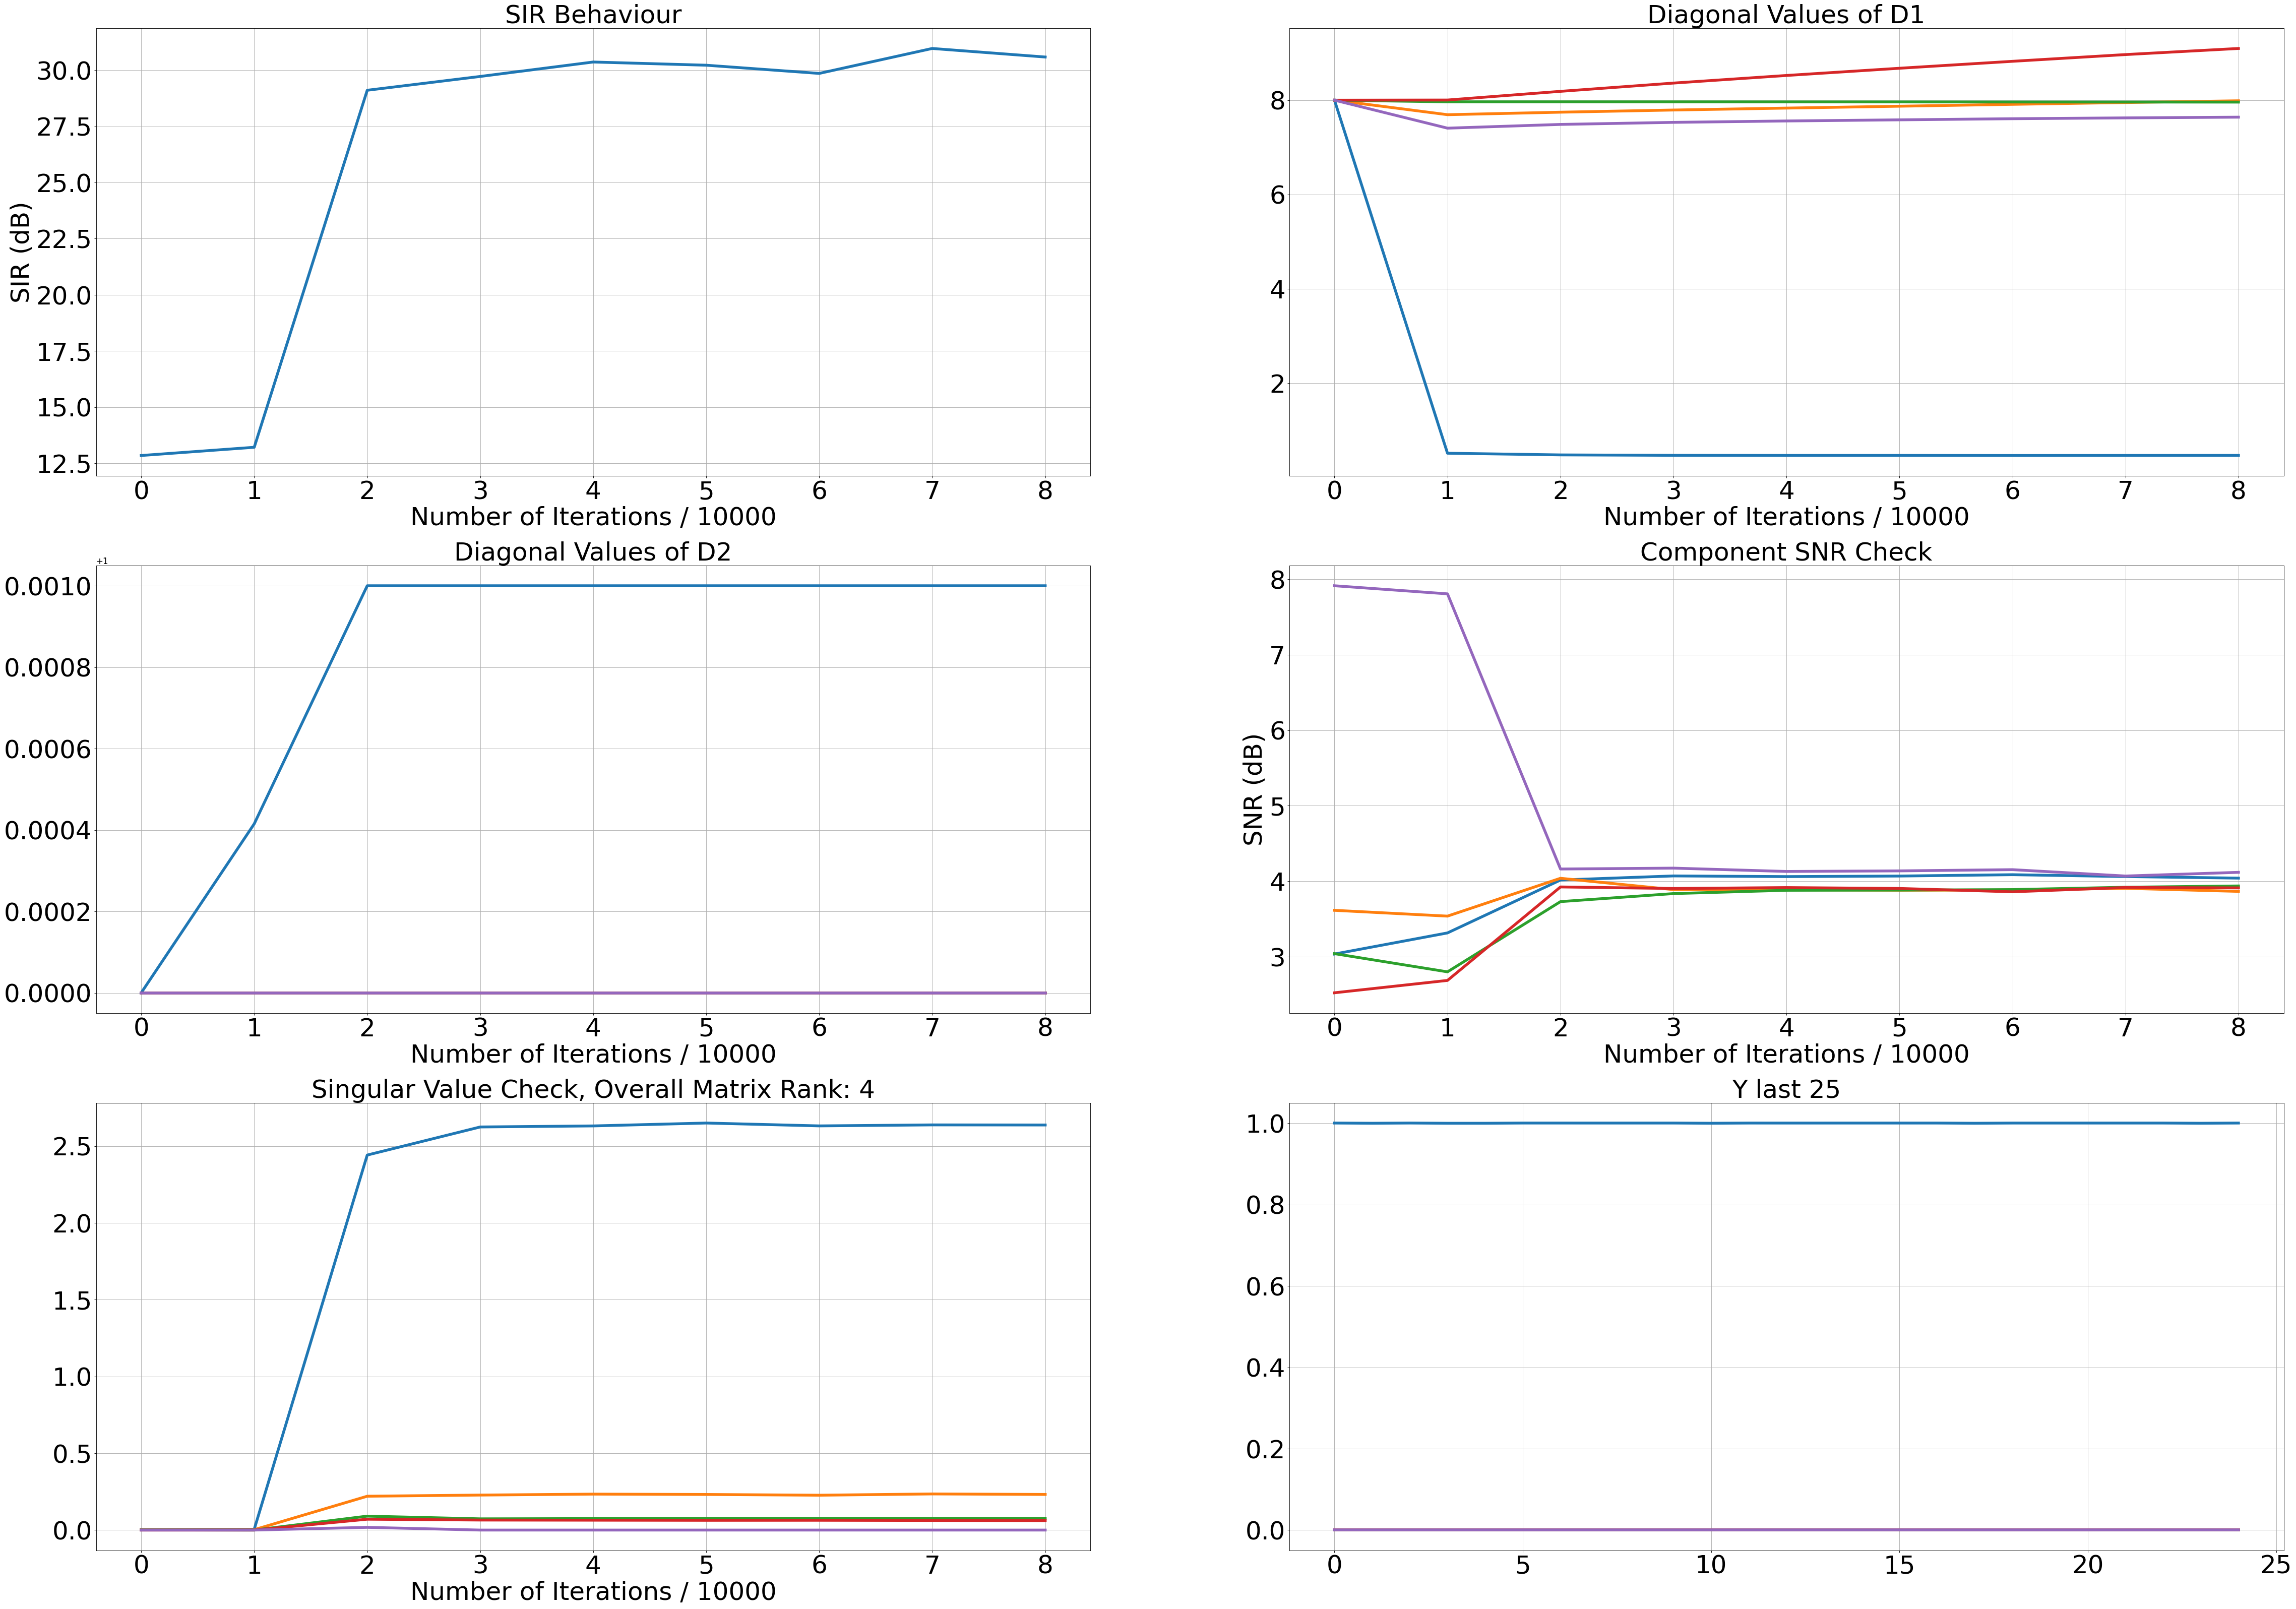

 18%|███████████▋                                                     | 90100/500000 [03:38<11:37, 587.70it/s]

SVD did not converge


 20%|████████████▊                                                   | 100062/500000 [03:54<10:29, 635.42it/s]

SVD did not converge


 22%|██████████████                                                  | 110066/500000 [04:09<09:39, 672.74it/s]

SVD did not converge


 24%|███████████████▎                                                | 120090/500000 [04:24<10:04, 628.82it/s]

SVD did not converge


 26%|████████████████▋                                               | 130094/500000 [04:38<09:21, 658.76it/s]

SVD did not converge


 28%|█████████████████▉                                              | 140116/500000 [04:52<08:09, 734.81it/s]

SVD did not converge


 30%|███████████████████▏                                            | 150078/500000 [05:06<08:35, 678.86it/s]

SVD did not converge


 32%|████████████████████▍                                           | 160107/500000 [05:19<07:17, 777.12it/s]

SVD did not converge


 34%|█████████████████████▍                                          | 167889/500000 [05:30<11:14, 492.64it/s]

In [ ]:
debug_iteration_point = 10000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

model.fit_batch_simplex(X, n_epochs = 1, neural_lr_start = 0.5, shuffle = False,
                       debug_iteration_point = debug_iteration_point, 
                       plot_in_jupyter = True)

In [ ]:
S.std(axis = 1)

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T , S)[0])

print("Overall SINR : {}".format(SINRwsm))

In [ ]:
CalculateSIR(A, Wf)

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [ ]:
import mir_eval

In [ ]:
S.shape, Y_.T.shape

In [ ]:
mir_eval.separation.bss_eval_sources(S, Y_.T,
                     compute_permutation=True)